This notebook demonstrates the basic usage of the AUM score. 

The experiment creates 3 different plots:
1. AUROC vs model complexity (num_estimators)
2. AUM score historgram for the maximum number of estimators
3. Average AUM score vs model complexity for clean and noisy labels

A general observation is that the AUM score is sensitive to the complexity of the model.
With simpler models, the AUROC seems to be higher.

The sweet spot depends on the dataset, noise type and noise level and cannot be generalized.
For more insights, please refer to the notebook: *hyperparameter_study.ipynb*

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from src.data import load_dataset
from src.models import get_model_default_kwargs_for_ds
from src.label_noise import (
    generate_noisy_labels, 
    create_uniform_transition_matrix,
    create_asymmetric_transition_matrix,
)
from src.scoring import compute_AUM_scores
from src.viz import (
    plot_auroc,
    plot_histogram, 
    plot_differences,
)

# Set the path to the datasets
DATASET_DIR = "../datasets"

In [2]:
def experiment(
        dataset_name: str,
        noise_type: str,
        noise_level: float,
        n_estimators: int=None,
        max_depth: int=None,
        save_dir: str=None,
        random_state: int=42,
        **kwargs
    ) -> None:
    """
    Run an experiment to evaluate the label quality score on a noisy dataset.
    
    Parameters
    ----------
    dataset_name : str
        The name of the dataset to load.
    noise_type : str
        The type of noise to generate. Either "uniform" or "asymmetric".
    noise_level : float
        The level of noise to generate.
    n_estimators : int
        The number of estimators to use in the XGBoost model.
        If None, the default value for the dataset will be used.
    max_depth : int
        The maximum depth of the trees in the XGBoost model.
        If None, the default value for the dataset will be used.
    save_dir : str
        The directory to save/load the dataset to/from.
    random_state : int
        The random state to use for reproducibility.
    """

    # Load the dataset
    X, y = load_dataset(dataset_name, save_dir, **kwargs)

    # Generate transition matrix
    n_classes = len(np.unique(y))
    if noise_type == "uniform":
        transition_matrix = create_uniform_transition_matrix(
            n_classes=n_classes, noise_level=noise_level
        )
    elif noise_type == "asymmetric":
        transition_matrix = create_asymmetric_transition_matrix(
            n_classes=n_classes, noise_level=noise_level
        )
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")

    # Generate noisy labels
    y_noisy, noise_mask = generate_noisy_labels(
        y, transition_matrix, random_state
    )

    # Get the default model kwargs for the dataset
    kwargs = get_model_default_kwargs_for_ds(dataset_name)
    if n_estimators is not None:
        kwargs["n_estimators"] = n_estimators
    if max_depth is not None:
        kwargs["max_depth"] = max_depth

    # Train a model on noisy data 
    model = XGBClassifier(**kwargs, random_state=random_state)
    model.fit(X, y_noisy)

    # Compute the label quality scores
    scores = compute_AUM_scores(model, X, y_noisy)
    overall_score = np.mean(scores, axis=1)

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plot_auroc(ax[0], scores, noise_mask)
    plot_histogram(ax[1], overall_score, noise_mask)
    plot_differences(ax[2], scores, noise_mask)
    plt.tight_layout()
    plt.show()

### Digits

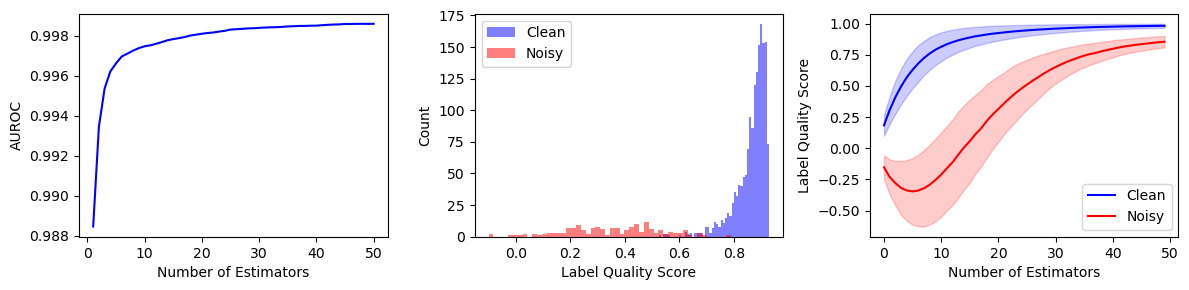

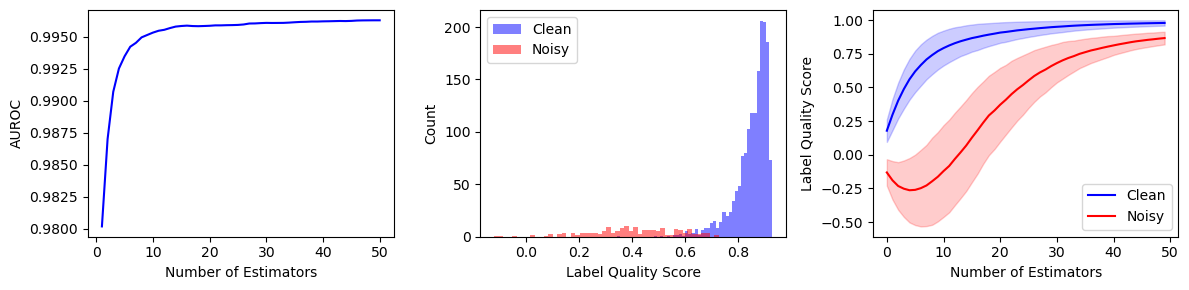

In [3]:
experiment("digits", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("digits", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Spirals

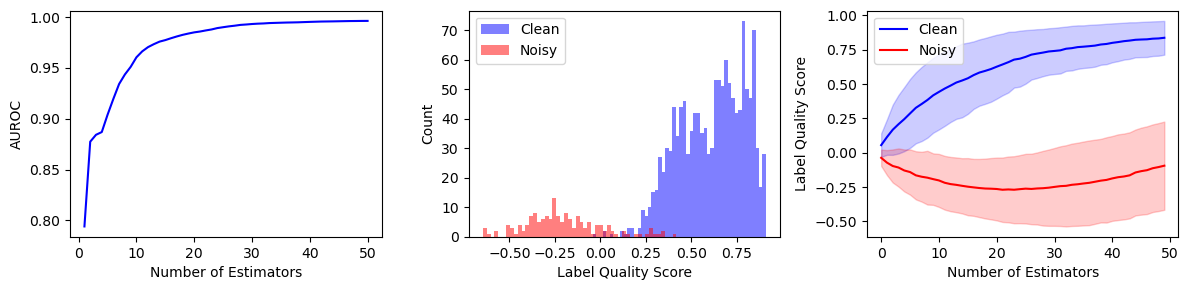

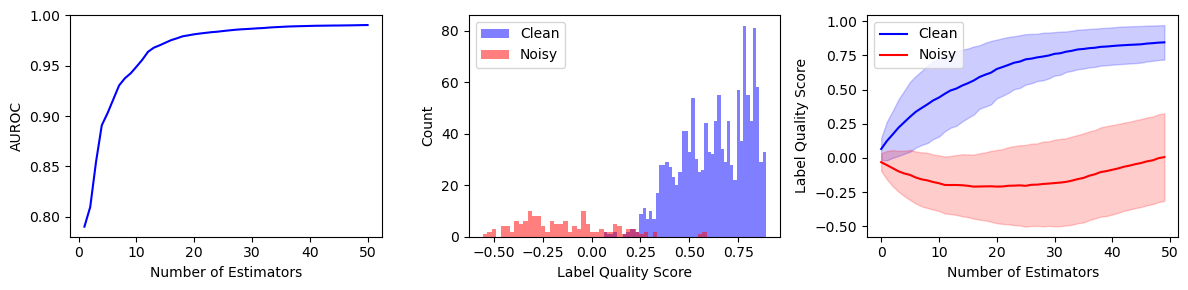

In [4]:
experiment("spirals", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("spirals", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Letters

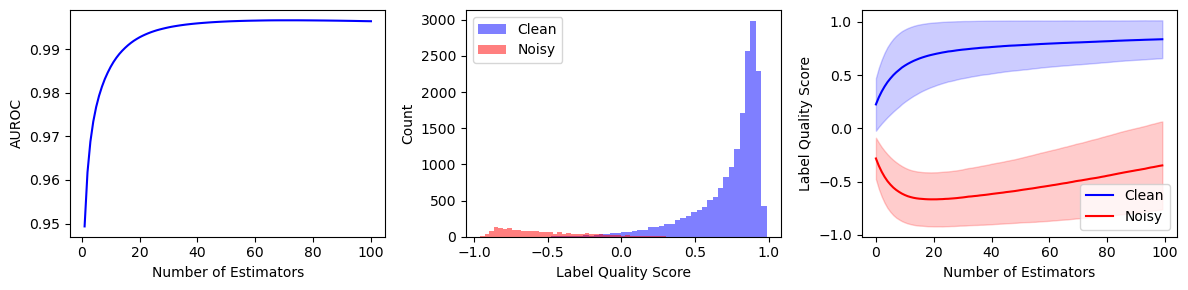

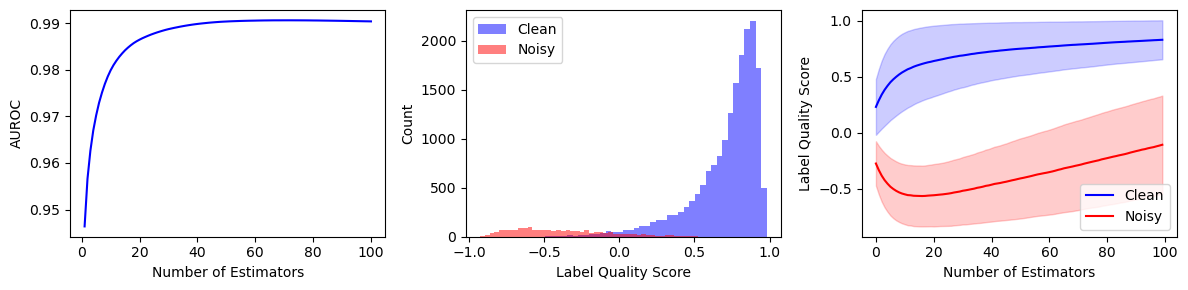

In [5]:
experiment("letters", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("letters", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Mushrooms

Only has 2 classes, so uniform and asymmetric are the same.

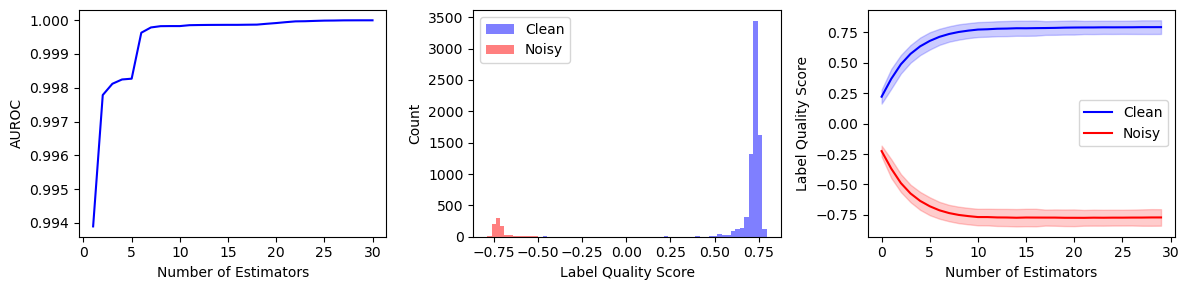

In [6]:
experiment("mushrooms", noise_type="uniform", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Satelite

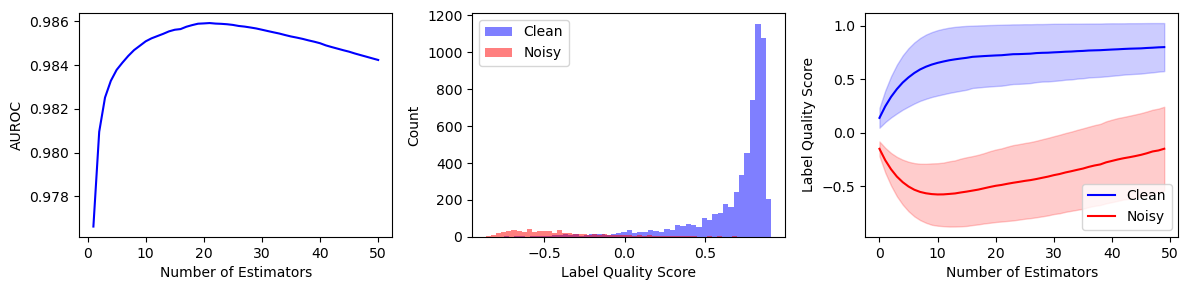

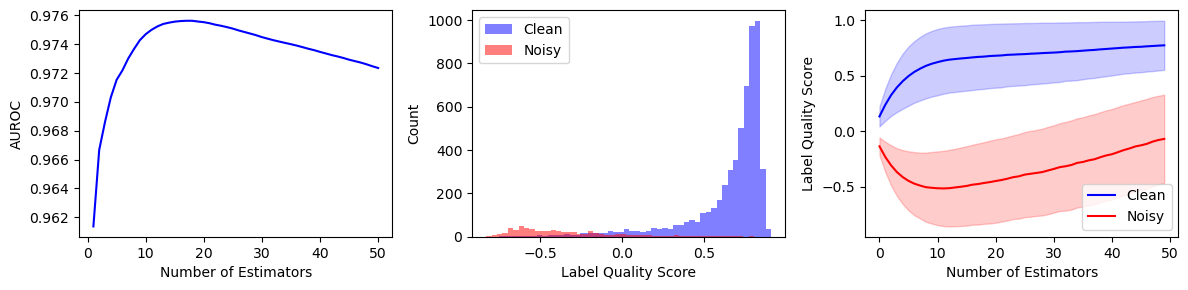

In [7]:
experiment("satelite", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("satelite", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Sensorless Drive

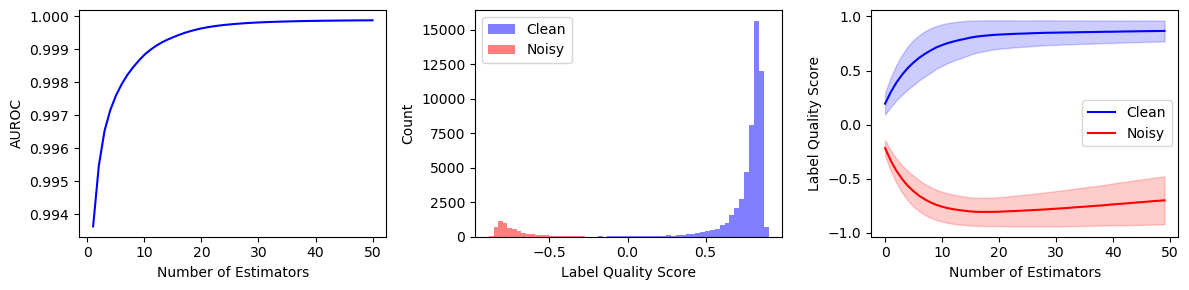

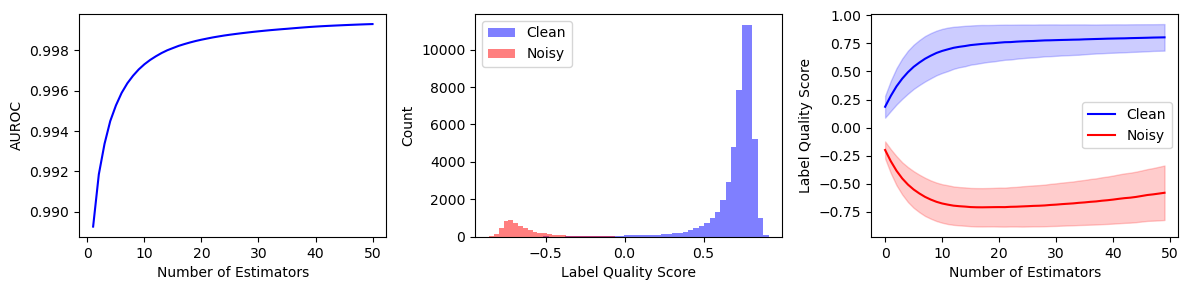

In [8]:
experiment("sensorless_drive", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("sensorless_drive", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Cardiotocography

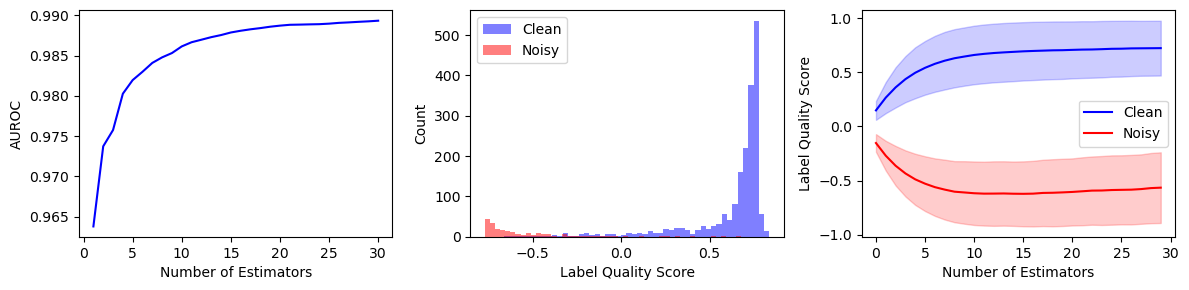

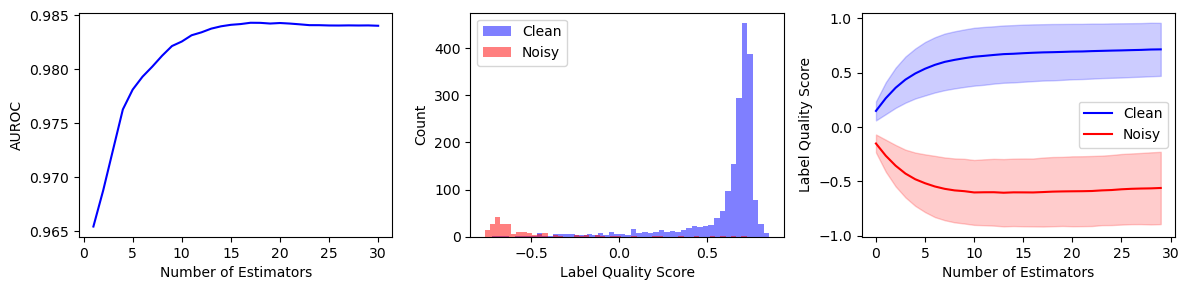

In [9]:
experiment("cardiotocography", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("cardiotocography", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Credit Card Fraud

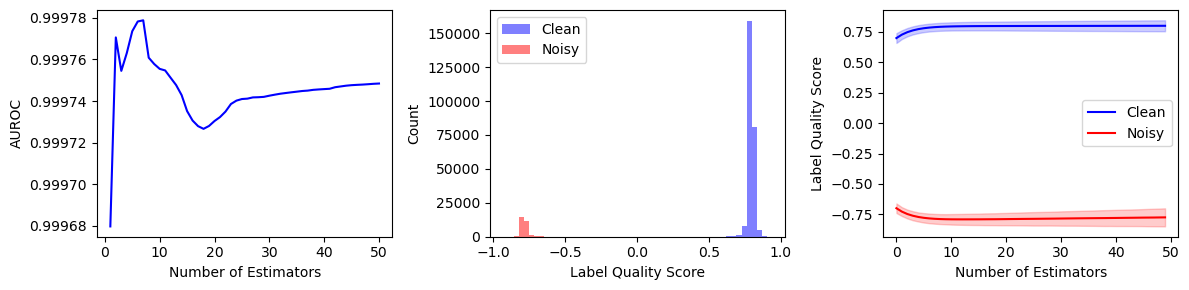

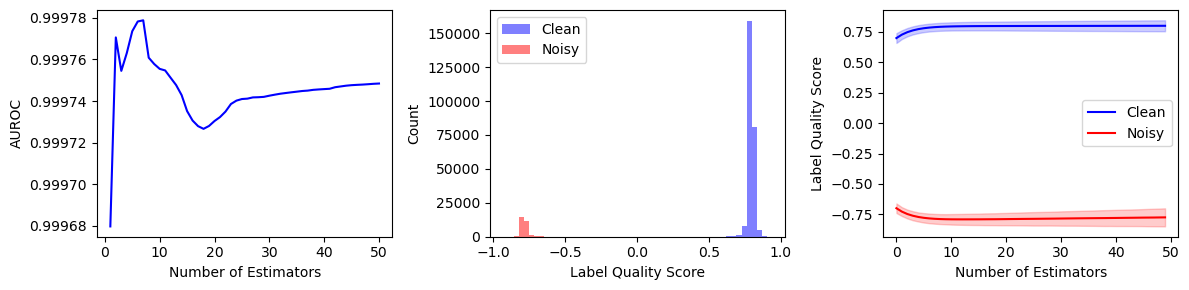

In [10]:
experiment("credit_card_fraud", noise_type="uniform",    noise_level=0.1, DATASET_DIR=DATASET_DIR)
experiment("credit_card_fraud", noise_type="asymmetric", noise_level=0.1, DATASET_DIR=DATASET_DIR)

### Human Activity Recognition

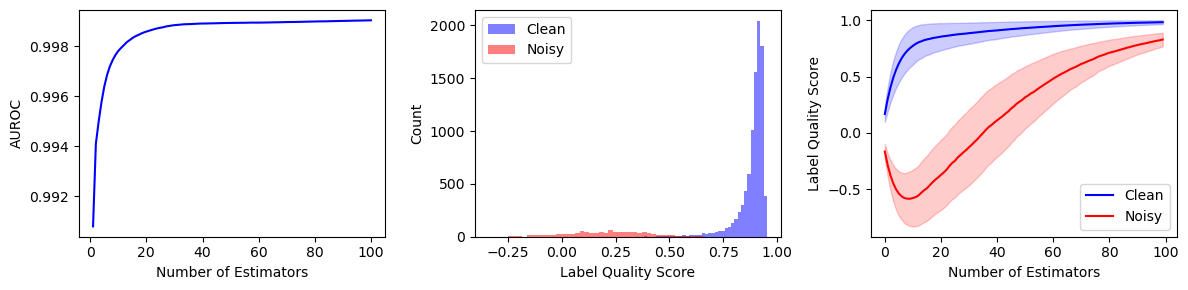

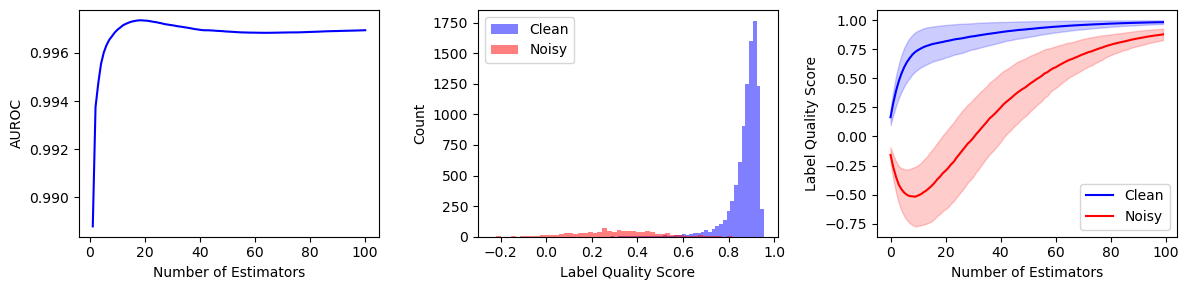

In [11]:
experiment("human_activity_recognition", noise_type="uniform",    noise_level=0.1, save_dir=DATASET_DIR)
experiment("human_activity_recognition", noise_type="asymmetric", noise_level=0.1, save_dir=DATASET_DIR)